In [1]:
import numpy as np

import aesara.tensor as at
from aesara.tensor.random.op import RandomVariable, default_shape_from_params

import sys

sys.path.insert(0, "/Users/larryshamalama/Documents/GitHub/pymc")

import pymc as pm

from pymc.distributions.continuous import assert_negative_support, UnitContinuous
from pymc.distributions.dist_math import betaln, bound, normal_lcdf
from pymc.distributions.distribution import Continuous

from pymc.distributions import transforms

from pymc.aesaraf import floatX, intX

# a bunch of imports for testing and printing

from aesara.tensor.basic import get_vector_length
from aesara.tensor.random.utils import params_broadcast_shapes
from aesara.tensor.shape import shape_tuple

import aesara

import matplotlib.pyplot as plt
import scipy.stats as st

%config InlineBackend.figure_format = "retina"
%matplotlib inline

print(f"pymc version: {pm.__version__}")
print(f"Aesara version: {aesara.__version__}")
print(f"pymc location: {pm.__file__}")

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


pymc version: 4.0.0
Aesara version: 2.2.1
pymc location: /Users/larryshamalama/Documents/GitHub/pymc/pymc/__init__.py


In [2]:
M = 3; K = 19

In [3]:
def stick_glueing(weights):
    shape = tuple(weights.shape or ())
    
    denominator = np.cumsum(
        np.concatenate(
            [
                np.ones(shape=shape[:-1] + (1,)),
                - weights,
            ],
            axis=-1,
        ),
        axis=-1,
    )
    
    output = (weights/(denominator[..., :-1]))
    
    return output[..., :-1]

## `StickBreakingWeightsRV`

In [4]:
class StickBreakingWeightsRV(RandomVariable):
    name = "stick_breaking_weights"
    ndim_supp = 1
    ndims_params = [0, 0]
    dtype = "floatX"
    _print_name = ("StickBreakingWeights", "\\operatorname{StickBreakingWeights}")
    
    def __call__(self, alpha=1., K=7, size=None, **kwargs):
        return super().__call__(alpha, K, size=size, **kwargs)

    def _infer_shape(self, size, dist_params, param_shapes=None):
        alpha, K = dist_params
        return [K + 1,]
    
    @classmethod
    def rng_fn(cls, rng, alpha, K, size):
        if K < 0:
            raise ValueError("K needs to be a positive integer.")
        
        if np.ndim(alpha) > 0:
            raise ValueError("The concentration parameter needs to be a scalar.")
            
        if size is None:
            size = (K,)
        elif isinstance(size, int):
            size = (size,) + (K,)
        else:
            size = tuple(size) + (K,)
            
        betas = rng.beta(1, alpha, size=size)
        
        sticks = np.concatenate(
            (
                np.ones(shape=(size[:-1] + (1,))),
                np.cumprod(1 - betas[..., :-1], axis=-1),
            ),
            axis=-1,
        )
        
        weights = sticks * betas
        weights = np.concatenate(
            (
                weights,
                1 - weights.sum(axis=-1)[..., np.newaxis]
            ),
            axis=-1,
        )

        return weights
    

stickbreakingweights = StickBreakingWeightsRV()

In [5]:
_ = stickbreakingweights(alpha=M, K=7, size=[10,]).eval()
# _ = stickbreakingweights(alpha=M, size=[100, 7]).eval()
# _ = stickbreakingweights(alpha=M, size=[10, 11, 7]).eval()

# stickbreakingweights(alpha=np.array([[1, 2], [4, 5]]), size=[10, 11, 7]).eval() # error

In [6]:
stickbreakingweights(alpha=M, K=19, size=(4, 5)).eval().shape

(4, 5, 20)

## Testing `rng_fn`

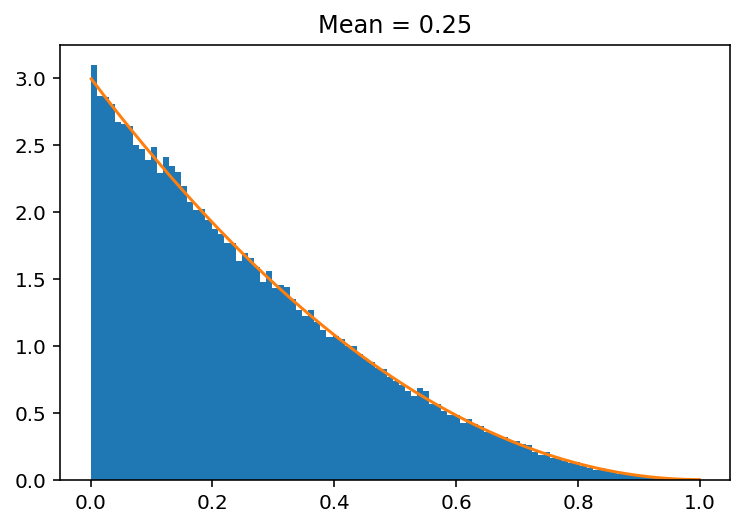

In [7]:
rng = np.random.RandomState(seed=34)
beta_draws = stick_glueing(stickbreakingweights(alpha=M, size=[1000, K]).eval()).reshape(-1,)

x_plot = np.linspace(start=0.001, stop=0.999, num=10001)

_ = plt.hist(beta_draws, bins=100, density=True)
_ = plt.plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M)
)
_ = plt.title(f"Mean = {np.around(beta_draws.mean(), 2)}")

In [8]:
class StickBreakingWeights(Continuous):
    rv_op = stickbreakingweights
    
    def __new__(cls, name, *args, **kwargs):
        kwargs.setdefault("transform", transforms.stick_breaking)
        return super().__new__(cls, name, *args, **kwargs)

    @classmethod
    def dist(cls, alpha, K, *args, **kwargs):
        alpha = at.as_tensor_variable(floatX(alpha))
        K = at.as_tensor_variable(intX(K))
        
        if alpha.ndim > 0:
            raise ValueError("alpha must be a scalar.")
            
        if K.ndim > 0:
            raise ValueError("K must be a scalar.")

        assert_negative_support(alpha, "alpha", "StickBreakingWeights")

        return super().dist([alpha, K], **kwargs)

    def logp(value, alpha, K):
        if at.lt(K, 0).eval():
            raise ValueError("K needs to be a positive integer.")
            
        if at.lt(alpha, 0).eval():
            raise ValueError("K needs to be a positive integer.") 
        
        logp = -at.sum(
            at.log(
                at.cumsum(
                    value[..., ::-1],
                    axis=-1,
                )
            ),
            axis=-1,
        )

        logp += -K * betaln(1, alpha)
        logp += alpha * at.log(value[..., -1])

        return bound(
            logp,
            alpha > 0,
            at.all(value >= 0),
            at.all(value <= 1),
        )

In [9]:
with pm.Model() as model:
    # check K = 5, something less crazy, 19 might run into precision issues quickly
    # check expectation of last bin
    # need upper bound to K with respect to M
    # if last value is 0, then inf would arise in one but not all
    
    # gradually grow α and see when it starts breaking
    sbw = StickBreakingWeights(name="sbw", alpha=M, K=19, shape=[3,])
    prior = pm.sample_prior_predictive(samples=2000,)
    trace = pm.sample(draws=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sbw]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [10]:
trace.to_dict()["posterior"]["sbw"][0].shape

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


(2000, 20)

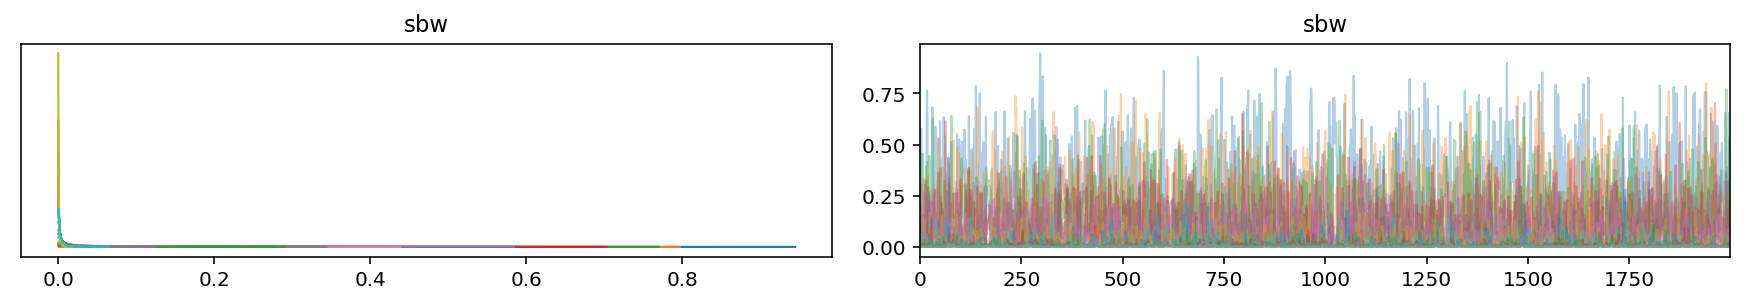

In [11]:
_ = pm.plot_trace(trace)

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


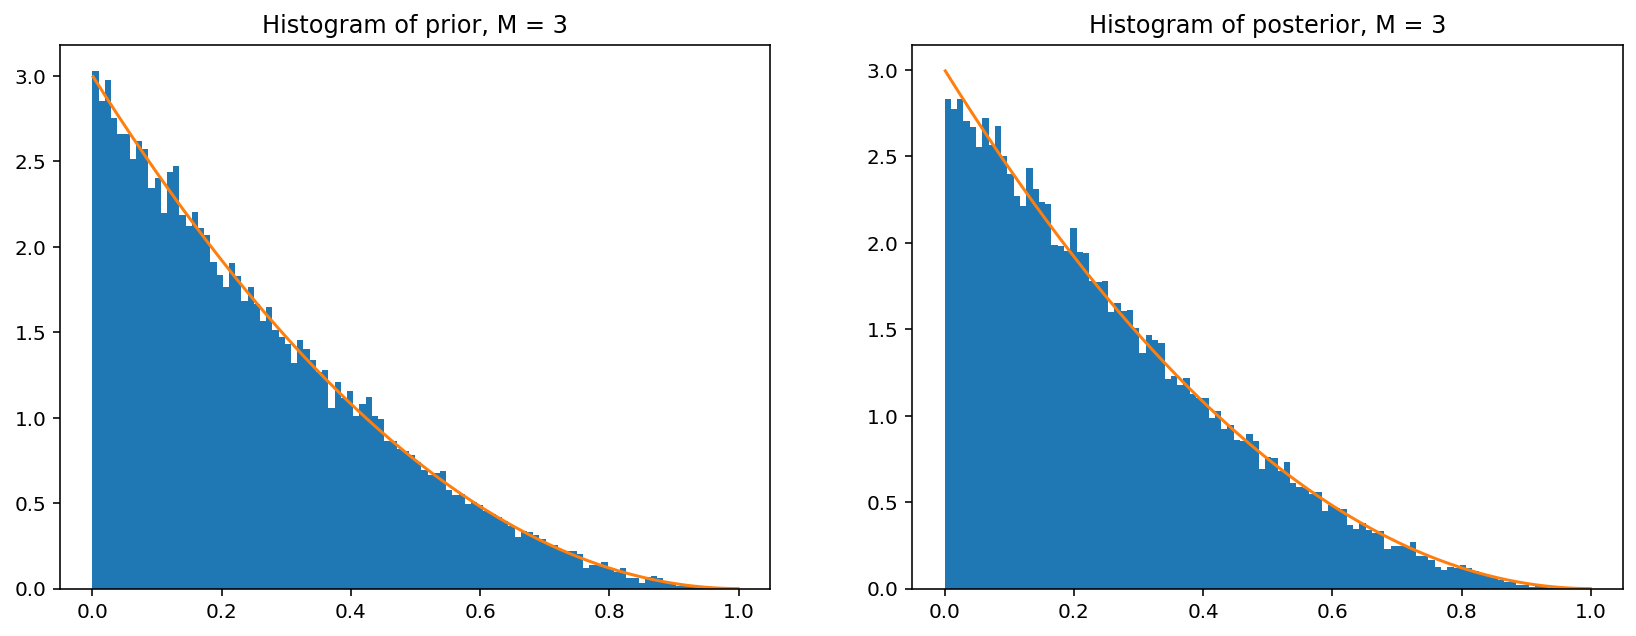

In [12]:
prior_beta_draws = stick_glueing(prior["sbw"]).reshape(-1,)
post_beta_draws = stick_glueing(trace.to_dict()["posterior"]["sbw"][0]).reshape(-1,)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

x_plot = np.linspace(start=0.001, stop=0.999, num=10001)

_ = axes[0].hist(prior_beta_draws, bins=100, density=True)
_ = axes[0].plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M),
)
_ = axes[0].set_title(f"Histogram of prior, M = {M}", fontsize=12)

_ = axes[1].hist(post_beta_draws, bins=100, density=True)
_ = axes[1].plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M),
)
_ = axes[1].set_title(f"Histogram of posterior, M = {M}", fontsize=12)

## Hierarchical Sample

In [13]:
with pm.Model() as model:
    α = pm.Gamma(name="α", alpha=4., beta=2.)
    sbw = StickBreakingWeights(name="sbw", alpha=α, K=11, shape=[3,])
    prior = pm.sample_prior_predictive(samples=2000,)
    trace = pm.sample(draws=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, sbw]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [18]:
pm.StickBreakingWeights.dist(2., 19, size=[3,]).eval().shape

(3, 20)